Librerias 

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

Datos 

In [24]:
train = pd.read_csv("train_muestra_ct.csv")
questions = pd.read_csv("questions.csv")

In [25]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,162814,2192514769,3459591,4406,0,155,0,0,11000.0,True
1,32681,324855427,786638,7093,0,114,2,1,34400.0,True
2,40971,335689585,1095916,9107,0,233,0,0,8000.0,True
3,63321,2397825389,1409904,1053,0,362,1,1,16000.0,True
4,186690,14882365329,3838215,3365,0,3255,2,1,27000.0,True


In [26]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


Datos derivados

In [27]:
# Unir metadata de las preguntas
questions = questions.rename(columns={"question_id": "content_id"})
train = train.merge(questions[["content_id", "part"]], on="content_id", how="left")

# Eliminar interacciones que no son preguntas
train = train[train['content_type_id'] == 0]

# Rellenar valores nulos
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].fillna(0)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(False).astype(bool).astype(int)

# ---- Features por usuario ----
user_stats = train.groupby('user_id')['answered_correctly'].agg(['mean', 'count']).reset_index()
user_stats.columns = ['user_id', 'user_accuracy', 'user_total_answers']
train = train.merge(user_stats, on='user_id', how='left')

# ---- Features por pregunta ----
question_stats = train.groupby('content_id')['answered_correctly'].agg(['mean', 'count']).reset_index()
question_stats.columns = ['content_id', 'question_accuracy', 'question_attempts']
train = train.merge(question_stats, on='content_id', how='left')

# ---- Tiempo promedio por usuario ----
user_time = train.groupby('user_id')['prior_question_elapsed_time'].mean().reset_index()
user_time.columns = ['user_id', 'user_avg_time_per_question']
train = train.merge(user_time, on='user_id', how='left')

# ---- Accuracy del usuario por parte ----
user_part = train.groupby(['user_id', 'part'])['answered_correctly'].mean().reset_index()
user_part.columns = ['user_id', 'part', 'user_part_accuracy']
train = train.merge(user_part, on=['user_id', 'part'], how='left')

C:\Users\ENRIQUE\AppData\Local\Temp\ipykernel_28804\3482556912.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(False).astype(bool).astype(int)


In [28]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,user_accuracy,user_total_answers,question_accuracy,question_attempts,user_avg_time_per_question,user_part_accuracy
0,162814,2192514769,3459591,4406,0,155,0,0,11000.0,1,5.0,0.517241,29,0.644193,2299,29614.896552,0.400000
1,32681,324855427,786638,7093,0,114,2,1,34400.0,1,7.0,0.615385,13,0.807080,565,22049.923077,1.000000
2,40971,335689585,1095916,9107,0,233,0,0,8000.0,1,5.0,0.692308,13,0.567130,432,26769.230769,0.692308
3,63321,2397825389,1409904,1053,0,362,1,1,16000.0,1,2.0,0.629630,27,0.699793,483,19703.703704,0.800000
4,186690,14882365329,3838215,3365,0,3255,2,1,27000.0,1,4.0,0.757576,264,0.303048,6923,22878.359848,0.761905


Procesamiento de Datos

In [29]:
features = [
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_accuracy',
    'user_total_answers',
    'question_accuracy',
    'question_attempts',
    'user_avg_time_per_question',
    'part',
    'user_part_accuracy'
]

# Eliminar filas con valores faltantes
train = train.dropna(subset=features + ['answered_correctly'])

X = train[features]
y = train['answered_correctly']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

XGBoost

1. Datos tabulares
El dataset es principalmente estructurado y tabular, donde XGBoost son muy efectivos.

2. Variables mixtas

Se tiene:
- Números (elapsed_time, user_total_answers, etc.)

- Categóricas codificadas (part, tag_count)

- Valores faltantes (que XGBoost maneja internamente)

- Los árboles pueden manejar todo esto sin requerir mucha transformación.

3. Interacciones no lineales

Por ejemplo: un usuario con experiencia (muchas respuestas) puede comportarse diferente dependiendo del tipo de pregunta (part, tags).




In [30]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.5,
    'tree_method': 'hist',
    'seed': 42
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=50
)


[0]	train-auc:0.71422	val-auc:0.71368
[50]	train-auc:0.84510	val-auc:0.84455
[100]	train-auc:0.84661	val-auc:0.84603
[150]	train-auc:0.84724	val-auc:0.84658
[200]	train-auc:0.84757	val-auc:0.84682
[250]	train-auc:0.84780	val-auc:0.84695
[300]	train-auc:0.84800	val-auc:0.84701
[350]	train-auc:0.84817	val-auc:0.84704
[400]	train-auc:0.84834	val-auc:0.84706
[450]	train-auc:0.84852	val-auc:0.84707
[491]	train-auc:0.84864	val-auc:0.84707


Evaluamos

In [31]:
y_pred = model.predict(dval) 
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC final: {auc_score:.5f}")

AUC final: 0.84707


Nuevo Dato

In [32]:
# Crear un nuevo dato artificial
nuevo_dato = pd.DataFrame([{
    'prior_question_elapsed_time': 23000,       # 23 segundos viendo la pregunta anterior
    'prior_question_had_explanation': 1,        # hubo explicación previa
    'user_accuracy': 0.68,                      # precisión histórica del usuario
    'user_total_answers': 150,                  # número total de respuestas del usuario
    'question_accuracy': 0.63,                  # tasa de aciertos de esta pregunta
    'question_attempts': 340,                   # cuántas veces se ha intentado esta pregunta
    'user_avg_time_per_question': 21000,        # tiempo promedio que tarda el usuario
    'part': 3,                                   # parte temática de la pregunta (entre 1 y 7 en Riiid)
    'user_part_accuracy': 0.70                  # precisión del usuario en esta parte
}])

In [33]:
dtest = xgb.DMatrix(nuevo_dato[features])
prediccion = model.predict(dtest)


print(f"Probabilidad de responder correctamente: {prediccion[0]:.4f}")


Probabilidad de responder correctamente: 0.5767


Mas datos

In [34]:
def generar_dato_aleatorio():
    return {
        'prior_question_elapsed_time': np.random.randint(10000, 40000),
        'prior_question_had_explanation': np.random.choice([0, 1]),
        'user_accuracy': np.random.uniform(0.4, 0.9),
        'user_total_answers': np.random.randint(20, 300),
        'question_accuracy': np.random.uniform(0.4, 0.85),
        'question_attempts': np.random.randint(100, 1000),
        'user_avg_time_per_question': np.random.randint(15000, 35000),
        'part': np.random.randint(1, 8),
        'user_part_accuracy': np.random.uniform(0.4, 0.9)
    }

# Crear 5 ejemplos
datos_sinteticos = pd.DataFrame([generar_dato_aleatorio() for _ in range(5)])

# Predecir
dtest = xgb.DMatrix(datos_sinteticos[features])
predicciones = model.predict(dtest)

# Mostrar resultados explicados
for i, (fila, prob) in enumerate(zip(datos_sinteticos.to_dict(orient='records'), predicciones)):
    print(f"\n Ejemplo {i+1}")
    print(f"- Tiempo viendo pregunta anterior: {fila['prior_question_elapsed_time']/1000:.1f} segundos")
    print(f"- ¿Vio explicación antes?: {'Sí' if fila['prior_question_had_explanation'] == 1 else 'No'}")
    print(f"- Precisión histórica del usuario: {fila['user_accuracy']:.2f}")
    print(f"- Total de respuestas del usuario: {fila['user_total_answers']}")
    print(f"- Precisión global de la pregunta: {fila['question_accuracy']:.2f}")
    print(f"- Número de intentos sobre esta pregunta: {fila['question_attempts']}")
    print(f"- Tiempo promedio del usuario por pregunta: {fila['user_avg_time_per_question']/1000:.1f} segundos")
    print(f"- Parte temática (1-7): {fila['part']}")
    print(f"- Precisión del usuario en esta parte: {fila['user_part_accuracy']:.2f}")
    print(f" **Probabilidad de responder correctamente:** {prob:.4f}")


 Ejemplo 1
- Tiempo viendo pregunta anterior: 14.7 segundos
- ¿Vio explicación antes?: No
- Precisión histórica del usuario: 0.64
- Total de respuestas del usuario: 65
- Precisión global de la pregunta: 0.78
- Número de intentos sobre esta pregunta: 208
- Tiempo promedio del usuario por pregunta: 17.3 segundos
- Parte temática (1-7): 3
- Precisión del usuario en esta parte: 0.62
 **Probabilidad de responder correctamente:** 0.6779

 Ejemplo 2
- Tiempo viendo pregunta anterior: 39.2 segundos
- ¿Vio explicación antes?: No
- Precisión histórica del usuario: 0.48
- Total de respuestas del usuario: 70
- Precisión global de la pregunta: 0.58
- Número de intentos sobre esta pregunta: 726
- Tiempo promedio del usuario por pregunta: 19.2 segundos
- Parte temática (1-7): 6
- Precisión del usuario en esta parte: 0.85
 **Probabilidad de responder correctamente:** 0.7697

 Ejemplo 3
- Tiempo viendo pregunta anterior: 26.9 segundos
- ¿Vio explicación antes?: No
- Precisión histórica del usuario: 0.

# Simulemos todo el examen

In [35]:
preguntas_examen = questions.sample(10, random_state=42)[['content_id', 'part']].reset_index(drop=True)

usuario = {
    'user_accuracy': 0.72,
    'user_total_answers': 150,
    'user_avg_time_per_question': 23000,
    'user_part_accuracy': {p: np.random.uniform(0.6, 0.85) for p in range(1, 8)}
}

# Generar las features para cada pregunta
def construir_fila(content_id, part, usuario):
    return {
        'prior_question_elapsed_time': np.random.randint(15000, 30000),
        'prior_question_had_explanation': np.random.choice([0, 1]),
        'user_accuracy': usuario['user_accuracy'],
        'user_total_answers': usuario['user_total_answers'],
        'question_accuracy': np.random.uniform(0.5, 0.85),
        'question_attempts': np.random.randint(100, 1000),
        'user_avg_time_per_question': usuario['user_avg_time_per_question'],
        'part': part,
        'user_part_accuracy': usuario['user_part_accuracy'].get(part, usuario['user_accuracy'])
    }

# Dataset de simulación
datos_examen = pd.DataFrame([
    construir_fila(row['content_id'], row['part'], usuario)
    for _, row in preguntas_examen.iterrows()
])

# Predecir
dtest = xgb.DMatrix(datos_examen[features])
predicciones = model.predict(dtest)


aciertos_esperados = predicciones.sum()
porcentaje_estimado = aciertos_esperados / len(predicciones)

print(f"\n Examen simulado:")
print(f"- Total de preguntas: {len(predicciones)}")
print(f"- Aciertos estimados: {round(aciertos_esperados)} / {len(predicciones)}")
print(f"Porcentaje estimado de aciertos: {porcentaje_estimado * 100:.2f}%\n")

print("Detalle por pregunta:")
for i, (p, prob) in enumerate(zip(preguntas_examen['part'], predicciones)):
    print(f"- Pregunta {i+1}: Part {p} → Probabilidad de acierto: {prob:.4f}")


 Examen simulado:
- Total de preguntas: 10
- Aciertos estimados: 7 / 10
Porcentaje estimado de aciertos: 71.78%

Detalle por pregunta:
- Pregunta 1: Part 6 → Probabilidad de acierto: 0.7840
- Pregunta 2: Part 5 → Probabilidad de acierto: 0.8424
- Pregunta 3: Part 6 → Probabilidad de acierto: 0.3983
- Pregunta 4: Part 5 → Probabilidad de acierto: 0.8399
- Pregunta 5: Part 2 → Probabilidad de acierto: 0.6274
- Pregunta 6: Part 2 → Probabilidad de acierto: 0.5544
- Pregunta 7: Part 6 → Probabilidad de acierto: 0.8186
- Pregunta 8: Part 5 → Probabilidad de acierto: 0.8560
- Pregunta 9: Part 5 → Probabilidad de acierto: 0.6285
- Pregunta 10: Part 4 → Probabilidad de acierto: 0.8290


In [36]:
# Resultado total
aciertos_esperados = predicciones.sum()
porcentaje_estimado = aciertos_esperados / len(predicciones)

print(f"\nExamen simulado:")
print(f"- Total de preguntas: {len(predicciones)}")
print(f"- Aciertos esperados:  {round(aciertos_esperados)} redondeado")
print(f"- Porcentaje estimado de aciertos: {porcentaje_estimado * 100:.2f}%")

# Detalle por pregunta
print("\n Detalle por pregunta:")
for i, (p, prob) in enumerate(zip(preguntas_examen['part'], predicciones)):
    print(f"- Pregunta {i+1}: Part {p} → Probabilidad de acierto: {prob:.4f}")

# Análisis por sección (part)
print("\n Desglose por sección:")
datos_examen['part'] = preguntas_examen['part']
datos_examen['probabilidad_acierto'] = predicciones

resumen_part = datos_examen.groupby('part').agg(
    preguntas=('probabilidad_acierto', 'count'),
    aciertos_esperados=('probabilidad_acierto', 'sum')
).reset_index()

resumen_part['porcentaje'] = 100 * resumen_part['aciertos_esperados'] / resumen_part['preguntas']

for _, row in resumen_part.iterrows():
    print(f"- Part {int(row['part'])}: {int(row['preguntas'])} preguntas → "
          f"{row['aciertos_esperados']:.2f} aciertos esperados → "
          f"{row['porcentaje']:.2f}% de precisión estimada")



Examen simulado:
- Total de preguntas: 10
- Aciertos esperados:  7 redondeado
- Porcentaje estimado de aciertos: 71.78%

 Detalle por pregunta:
- Pregunta 1: Part 6 → Probabilidad de acierto: 0.7840
- Pregunta 2: Part 5 → Probabilidad de acierto: 0.8424
- Pregunta 3: Part 6 → Probabilidad de acierto: 0.3983
- Pregunta 4: Part 5 → Probabilidad de acierto: 0.8399
- Pregunta 5: Part 2 → Probabilidad de acierto: 0.6274
- Pregunta 6: Part 2 → Probabilidad de acierto: 0.5544
- Pregunta 7: Part 6 → Probabilidad de acierto: 0.8186
- Pregunta 8: Part 5 → Probabilidad de acierto: 0.8560
- Pregunta 9: Part 5 → Probabilidad de acierto: 0.6285
- Pregunta 10: Part 4 → Probabilidad de acierto: 0.8290

 Desglose por sección:
- Part 2: 2 preguntas → 1.18 aciertos esperados → 59.09% de precisión estimada
- Part 4: 1 preguntas → 0.83 aciertos esperados → 82.90% de precisión estimada
- Part 5: 4 preguntas → 3.17 aciertos esperados → 79.17% de precisión estimada
- Part 6: 3 preguntas → 2.00 aciertos esper

C:\Users\ENRIQUE\AppData\Local\Temp\ipykernel_28804\1267730290.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='part', y='aciertos_esperados', data=resumen_part, palette="viridis")
C:\Users\ENRIQUE\AppData\Local\Temp\ipykernel_28804\1267730290.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='part', y='porcentaje', data=resumen_part, palette="magma")


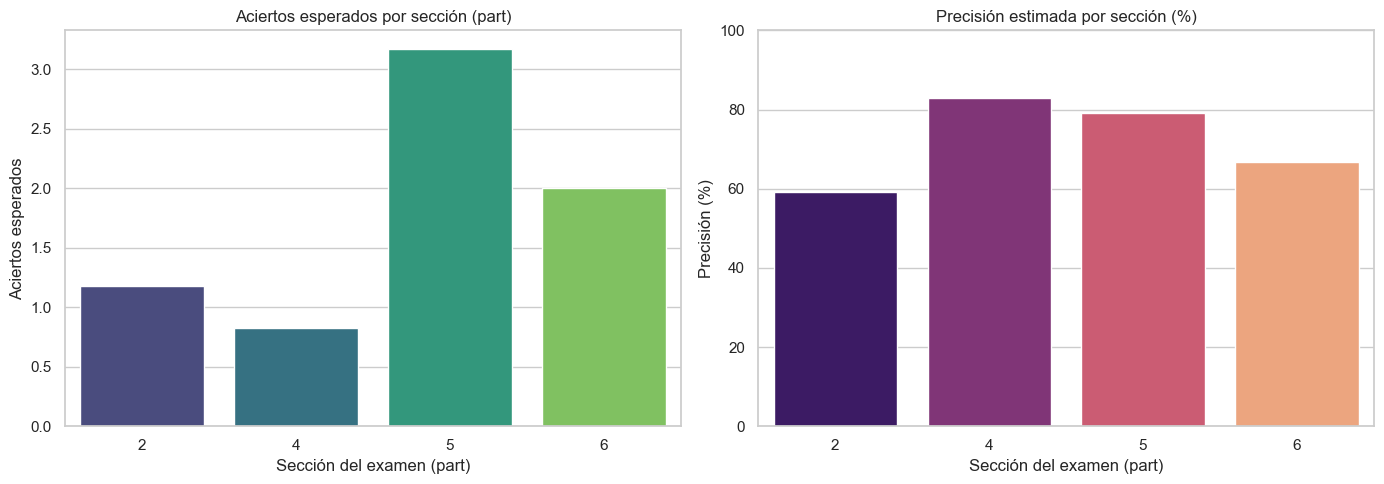

In [37]:
# Estilo general
sns.set(style="whitegrid")
plt.figure(figsize=(14, 5))

# Gráfico 1: Aciertos esperados por sección
plt.subplot(1, 2, 1)
sns.barplot(x='part', y='aciertos_esperados', data=resumen_part, palette="viridis")
plt.title("Aciertos esperados por sección (part)")
plt.xlabel("Sección del examen (part)")
plt.ylabel("Aciertos esperados")

# Gráfico 2: Porcentaje estimado por sección
plt.subplot(1, 2, 2)
sns.barplot(x='part', y='porcentaje', data=resumen_part, palette="magma")
plt.title("Precisión estimada por sección (%)")
plt.xlabel("Sección del examen (part)")
plt.ylabel("Precisión (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()


# Probamos con un dato existente

In [38]:
# Elegimos un usuario real y una pregunta real del dataset
ejemplo_real = train.sample(1, random_state=142)  

print("\n Predicción con un dato real del dataset:")
print(ejemplo_real[['user_id', 'content_id', 'answered_correctly']])

X_ejemplo = ejemplo_real[features]
dtest = xgb.DMatrix(X_ejemplo)

# Predecir
probabilidad = model.predict(dtest)[0]

print(f"\nProbabilidad estimada de responder correctamente: {probabilidad:.4f}")
print(f"Respuesta real: {'Correcta ' if ejemplo_real['answered_correctly'].values[0] == 1 else 'Incorrecta '}")



 Predicción con un dato real del dataset:
          user_id  content_id  answered_correctly
551650  303669058       10685                   1

Probabilidad estimada de responder correctamente: 0.7475
Respuesta real: Correcta 
